## Exploratory data analysis

In [2]:
import pandas as pd
import os
import sys


parent_dir = os.path.join('/home/leandre/Projects/BioMoQA_Playground/')
# Add it to sys.path
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
from src.data_pipeline.biomoqa.preprocess_biomoqa import biomoqa_data_pipeline

2025-06-24 01:30:19,294 - INFO - Optional negatives loaded from CSV with 5000 entries.
2025-06-24 01:30:19,295 - INFO - Loading original negatives...
2025-06-24 01:30:19,304 - INFO - Negatives column names: ['Article ID', 'Title', 'Author', 'Publication year', 'Title secondary', 'URL', 'DOI', 'Abstract', 'Criteria for exclusion A', ' Criteria for exclusion B', ' Criteria for exclusion C', 'labels', 'Keywords']
2025-06-24 01:30:19,304 - INFO - Loading original positives...
2025-06-24 01:30:19,321 - INFO - Positives column names: ['Article ID', 'Title', 'Author', 'Secondary authors', 'Keywords', 'title of unpublished reference', 'primary date', 'publication year', 'notes', 'reprint status', 'start page number', 'ending page number', 'periodical full name', 'periodical standard abbreviation', 'periodical in which article was published', 'periodical name - user abbreviation 1', 'periodical name - user abbreviation 2', 'volume number', 'issue number', 'title secondary', 'city of publication

2025-06-24 01:30:19,350 - INFO - Conflicts on title (same value, multiple labels):
Empty DataFrame
Columns: [title, n_labels]
Index: []
2025-06-24 01:30:19,354 - INFO - Total duplicate abstract: 0
2025-06-24 01:30:19,366 - INFO - Conflicts on abstract (same value, multiple labels):
Empty DataFrame
Columns: [abstract, n_labels]
Index: []
2025-06-24 01:30:19,368 - INFO - Total duplicate doi: 18
2025-06-24 01:30:19,372 - INFO - Conflicts on doi (same value, multiple labels):
Empty DataFrame
Columns: [doi, n_labels]
Index: []
2025-06-24 01:30:19,373 - INFO - Cleaned dataset size: 1396
2025-06-24 01:30:19,374 - INFO - Number of positives : 293
2025-06-24 01:30:19,375 - INFO - Number of negatives : 1103
2025-06-24 01:30:19,376 - INFO - clean_og_df size : 397
2025-06-24 01:30:19,376 - INFO - opt_neg_df size : 999
2025-06-24 01:30:19,382 - INFO - Fold 1:
2025-06-24 01:30:19,382 - INFO -   Train label distribution: {-1: 0.8181818181818182, 1: 0.13431613431613432, 0: 0.0475020475020475}
2025-06-

Stringifying the column:   0%|          | 0/1396 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/1396 [00:00<?, ? examples/s]

2025-06-24 01:30:19,459 - INFO - Number of positives : 293
2025-06-24 01:30:19,461 - INFO - Number of negatives : 1103
2025-06-24 01:30:19,462 - INFO - All 4 test‐folds in run 1 are pairwise disjoint.


0     Invasive
1      mammals
2        exert
3    pervasive
4      effects
dtype: object


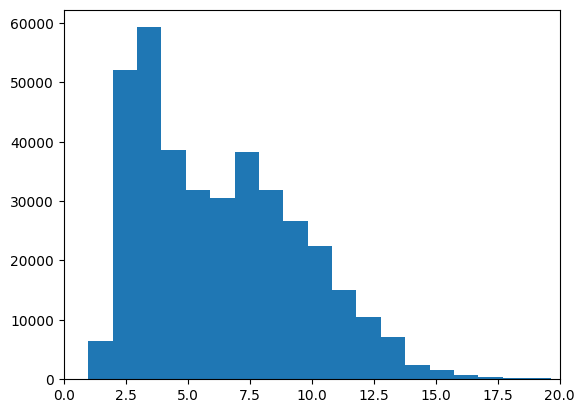

In [3]:
import matplotlib.pyplot as plt

dataset,folds_per_run=biomoqa_data_pipeline(4,1,with_title=True,with_keywords=False,nb_optional_negs=1000)
vocab=[pd.Series(dataset.to_pandas()["abstract"][i].split(" ")) for i in range(len(dataset))]
vocab=pd.concat(vocab)
print(vocab.head())

plt.hist(vocab.str.len(),bins=vocab.str.len().unique().max())
plt.xlim([0, 20])
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/leandre/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


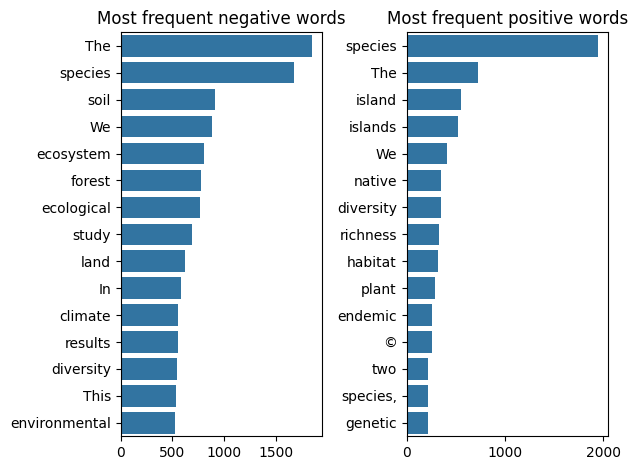

In [4]:

import nltk
from nltk.corpus import stopwords
import seaborn as sns
import numpy as np
import spacy
from collections import Counter

nltk.download('stopwords')
stop=set(stopwords.words('english'))
abstracts_df=dataset.to_pandas()

xs=[]
ys=[]
for label in 0,1:
    corpus=[]
    absracts= abstracts_df[abstracts_df['labels']==label]['abstract'].str.split()
    absracts=absracts.values.tolist()
    corpus=[word for i in absracts for word in i]

    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1

    counter=Counter(corpus)
    most=counter.most_common()

    x, y= [], []
    for word,count in most:
        if (word not in stop):
            x.append(word)
            y.append(count)
    xs.append(x)
    ys.append(y)

fig, axes = plt.subplots(1, 2)
axes = axes.flatten()

for i in range(len(axes)):
    ax=axes[i]
    sns.barplot(x=ys[i][:15],y=xs[i][:15],ax=ax)
    ax.set_title("Most frequent positive words" if i==1 else "Most frequent negative words")

plt.tight_layout()
plt.show()

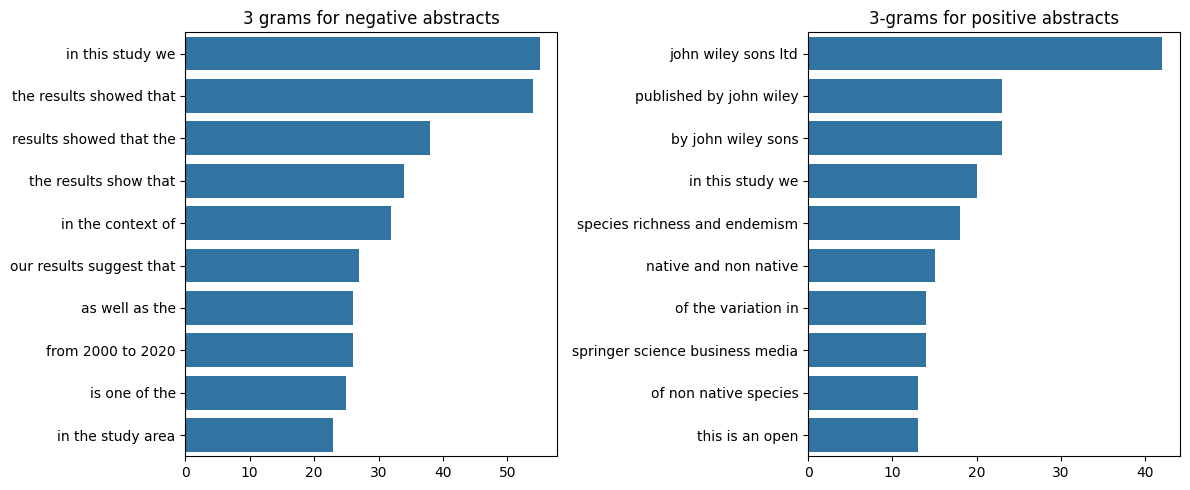

In [5]:
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.flatten()

for i in range(2):
    ax=axes[i]
    top_tri_grams=get_top_ngram(abstracts_df[abstracts_df['labels']==i]['abstract'],n=4)
    x,y=map(list,zip(*top_tri_grams))
    sns.barplot(x=y,y=x,ax=ax)
    ax.set_title("3-grams for positive abstracts" if i==1 else "3 grams for negative abstracts")
plt.tight_layout()
plt.show()

# Class distribution

In [ ]:
plt.pie(data=dataset.to_pandas(),
        x=dataset.to_pandas()['labels'].value_counts(),
        labels=['Negative', 'Positive'],
        autopct='%1.1f%%',
        startangle=90,
        colors=['#ff9999','#66b3ff'],
        explode=(0.1, 0.1))  # explode the slices for better visibility
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of Labels in BioMoQA Dataset')
plt.show()

AttributeError: module 'seaborn' has no attribute 'pie'

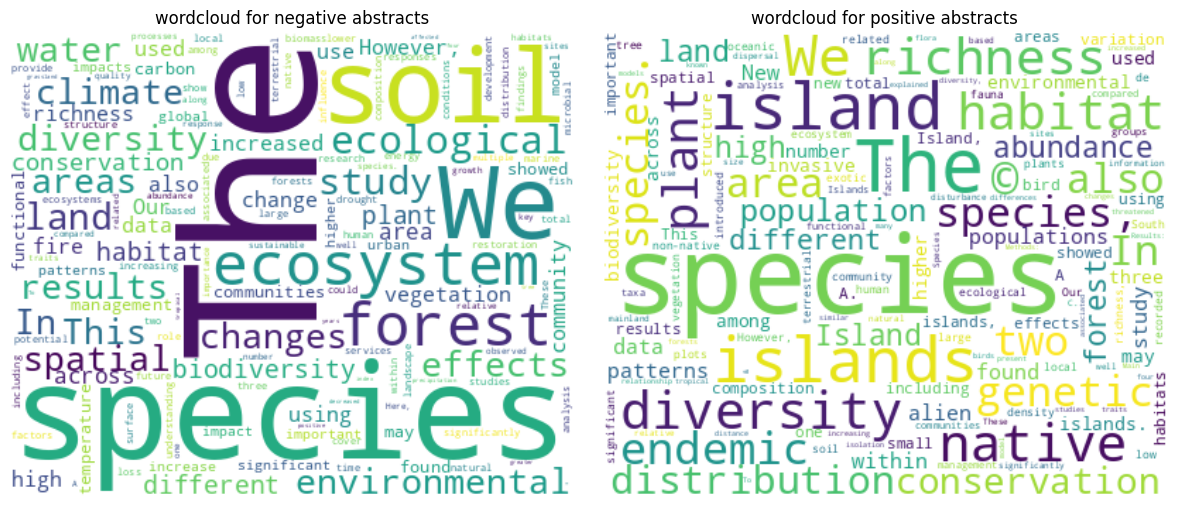

In [ ]:
from wordcloud import WordCloud

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes = axes.flatten()

for i in range(2):
  ax=axes[i]
  pos_word_dict = dict(zip(xs[i], ys[i]))
  wc = WordCloud(width=400, height=330, max_words=150,background_color="white",stopwords=stopwords).generate_from_frequencies(pos_word_dict)
  ax.imshow(wc, interpolation='bilinear')
  ax.set_title("wordcloud for positive abstracts" if i==1 else "wordcloud for negative abstracts")
  ax.axis(False)
plt.tight_layout()
plt.show()